### [최적의 모델 파라미터 찾기]

In [37]:
from sklearn.model_selection import RandomizedSearchCV

# 파라미터 후보군 선정
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]

# RandomizedSearchCV 오브젝트 생성
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
forest = RandomForestRegressor()
optimal_forest = RandomizedSearchCV(estimator = forest, 
                                    param_distributions = random_grid, 
                                    n_iter = 100, 
                                    cv = 3, 
                                    verbose=2,
                                    random_state=42, 
                                    n_jobs = -1)

# 모델 학습
X = df.loc[:, df.columns != 'price']
y = df['price']
optimal_forest.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.8min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

-----

##### 최적 파라미터 출력

In [38]:
optimal_forest.best_params_

{'n_estimators': 2000,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

-----

##### 최적 모델 학습 결과

MSE train: 8808359342.848, test: 7645657258.599
R^2 train: 0.818, test: 0.825


[('factory_price', 0.29646178523290273),
 ('maker_apple', 0.27561463622459076),
 ('phone_model_storage_16gb', 0.07214209431234403),
 ('create_time_score', 0.0657513685035865),
 ('product_status_2', 0.06263992520032223),
 ('phone_model_detail_galaxy s7 edge', 0.027077101189726924),
 ('phone_model_detail_iphone 6', 0.025028165789604363),
 ('product_status_0', 0.02443523519070575),
 ('phone_model_detail_galaxy s4', 0.020530253156036227),
 ('product_status_1', 0.01381250513598047)]

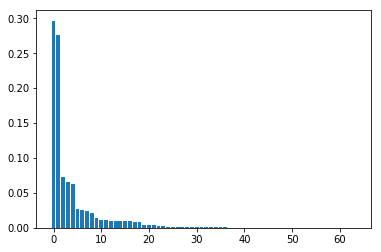

In [39]:
y_train_pred = optimal_forest.predict(X_train)
y_test_pred = optimal_forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 피처 중요도 plot
importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 피처 중요도 print
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, optimal_forest.best_estimator_.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

-----

##### 예측 결과 scatter plot

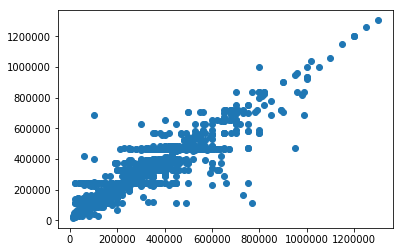

In [40]:
plt.scatter(y_test.values, y_test_pred)

-----

# <Step4. 프로토타입> : 얼마고(Almhago?)

### [재사용을 위한 파일 저장]

In [42]:
from sklearn.externals import joblib

with open('../data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'wb') as f:
    pickle.dump(model_to_factory_price_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/col_to_index_dict.pickle', 'wb') as f:
    pickle.dump(col_to_index_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/common_words.pickle', 'wb') as f:
    pickle.dump(common_words, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'wb') as f:
    pickle.dump(index_vectorizer.vocabulary_, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/svm_classifier.pickle', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)

joblib.dump(optimal_forest.best_estimator_, '../data/used_mobile_pickles/rf_regressor.pickle', compress = 1)

['../data/used_mobile_pickles/rf_regressor.pickle']

-----

### [가격 예측 프로그램 만들기]

##### 예측에 필요한 파일 로드

In [43]:
import pickle

with open('../data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'rb') as f:
    model_to_factory_price_dict = pickle.load(f)
    
with open('../data/used_mobile_pickles/col_to_index_dict.pickle', 'rb') as f:
    col_to_index_dict = pickle.load(f)
    
with open('../data/used_mobile_pickles/common_words.pickle', 'rb') as f:
    common_words = pickle.load(f)

with open('../data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'rb') as f:
    init_vectorizer_vocabulary = pickle.load(f)
    
with open('../data/used_mobile_pickles/tfidf_vectorizer.pickle', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
    
with open('../data/used_mobile_pickles/svm_classifier.pickle', 'rb') as f:
    svm_classifier = pickle.load(f)

rf_regressor = joblib.load('../data/used_mobile_pickles/rf_regressor.pickle')

-----

##### 프로그램(클래스) 만들기

In [44]:
import numpy as np

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


class Almhago():
    def __init__(self, model_to_factory_price_dict, col_to_index_dict, 
                 common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                 prd_status_classifier, price_regressor):
        self._model_to_factory_price_dict = model_to_factory_price_dict
        self._col_to_index_dict = col_to_index_dict
        self._common_words = common_words
        self._init_vectorizer_vocabulary = init_vectorizer_vocabulary
        self._index_vectorizer = self._init_index_vectorizer()
        self._tfidf_vectorizer = tfidf_vectorizer
        self._prd_status_classifier = prd_status_classifier
        self._price_regressor = price_regressor
        
    def _get_common_pos(self, x):
        tagger = Okt()
        poses = tagger.pos(x)
        return [pos[0] for pos in poses if pos[0] in self._common_words]
    
    def _text_cleaning(self, text):
        text = ''.join(c for c in text if c.isalnum() or c in '+, ')
        text = ''.join([i for i in text if not i.isdigit()])
        return text
        
    def _init_index_vectorizer(self):
        word_index_vectorizer = CountVectorizer(tokenizer = lambda x: self._get_common_pos(x))
        word_index_vectorizer.vocabulary_ = self._init_vectorizer_vocabulary
        return word_index_vectorizer
    
    def _get_ftr_price(self, model_name, storage):
        return self._model_to_factory_price_dict[(model_name, storage)]
    
    def _get_prd_status(self, text):
        X = self._index_vectorizer.transform([self._text_cleaning(program_test_dict['text'])])
        X = self._tfidf_vectorizer.transform(X)
        return self._prd_status_classifier.predict(X)[0]
    
    def _print_almhago(self, model, price, prd_status):
        status = ""
        if prd_status == "0":
            status = "불량한"
        elif prd_status == "1":
            status = "양호한"
        else:
            status = "좋은"
        print("선택하신", model, "모델은", status, "상태입니다. Almhago 예상 가격은", str(int(price[0])), "원 입니다.")
    
    def predict(self, input_dict):
        feature = np.zeros(64)
        feature[self._col_to_index_dict['factory_price']] = self._get_ftr_price(input_dict['phone_model_detail'],
                                                                                input_dict['phone_model_storage'])
        feature[self._col_to_index_dict['price_index']] = input_dict['price_index']
        feature[self._col_to_index_dict['create_time_score']] = input_dict['create_time_score']
        feature[self._col_to_index_dict["_".join(["maker", input_dict['maker']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_detail", input_dict['phone_model_detail']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_storage", input_dict['phone_model_storage']])]] = 1
        feature[self._col_to_index_dict["_".join(["product_status", self._get_prd_status(input_dict['text'])])]] = 1
        
        # predict result
        predicted_price = self._price_regressor.predict([feature])
        self._print_almhago(input_dict['phone_model_detail'], 
                            predicted_price, 
                            self._get_prd_status(input_dict['text']))

-----

##### 프로그램 테스트

In [45]:
recent_price_index = 95.96
recent_create_time_score = 1.0
program_test_dict = {"maker": "apple",
                     "phone_model_detail": "iphone 6",
                     "phone_model_storage": "16gb",
                     "text": '아이폰6 스페이스그레이 16기가 10만원에 팔아요~ 직접거래 \
                     메인보드 세척 완료 한 침수 폰 입니다폰 안켜지는 상테이구요 고쳐서 쓰실분 가져가세요10만원에 팔아요 \
                     리퍼한지 얼마안되서 기스 이런거 하나도 없습니당~서울 강남 근처 직거래 가능하며택배거래도 가능해요',
                     "price_index": recent_price_index,
                     "create_time_score": recent_create_time_score}

almhago = Almhago(model_to_factory_price_dict, col_to_index_dict, 
                  common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                  svm_classifier, rf_regressor)
almhago.predict(program_test_dict)

선택하신 iphone 6 모델은 불량한 상태입니다. Almhago 예상 가격은 152307 원 입니다.
